In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf
from gensim import models

In [36]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"


In [3]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [6]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    return np.sum(vectorized, axis=0)


In [7]:
df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].swifter.apply(lambda x: get_average_word2vec(x, word2vec))

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [8]:
X,y = df[TEXT_COLUMN_NAME],df[LABEL_COLUMN_NAME]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.5)

In [9]:
x_train = np.stack(x_train.values)
x_test = np.stack(x_test.values)

In [10]:
x_neg_weight = y[y==1].shape
x_pos_weight = y[y==0].shape
x_neg_weight[0]/x_pos_weight[0]
weights = {0: (x_neg_weight[0]/(x_pos_weight[0]+x_neg_weight[0])),1: (x_pos_weight[0]/(x_pos_weight[0]+x_neg_weight[0]))}
print(weights)

{0: 0.26771, 1: 0.73229}


In [11]:
x_train.shape

(80000, 300)

In [13]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout
model = Sequential()
model.add(Dense(280, activation="relu",input_shape=(300,)))
model.add(Dense(250, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(150, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 280)               84280     
_________________________________________________________________
dense_9 (Dense)              (None, 250)               70250     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 150)               37650     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               15100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)               

In [14]:
import tensorflow_addons as tfa
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=60*60*15, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(x_train,y_train,batch_size=200,epochs=1500,
                    validation_split=0.05,class_weight=weights,
                    use_multiprocessing=True,workers=8,callbacks=[callback,time_stopping_callback])

Epoch 1/1500
380/380 [==============================] - 3s 5ms/step - loss: 0.4013 - accuracy: 0.5721 - recall_1: 0.4234 - precision_1: 0.2916 - val_loss: 0.6503 - val_accuracy: 0.7092 - val_recall_1: 0.2720 - val_precision_1: 0.4545
Epoch 2/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.2851 - accuracy: 0.5894 - recall_1: 0.4727 - precision_1: 0.3182 - val_loss: 0.6452 - val_accuracy: 0.6963 - val_recall_1: 0.3228 - val_precision_1: 0.4320
Epoch 3/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.2756 - accuracy: 0.5817 - recall_1: 0.5396 - precision_1: 0.3274 - val_loss: 0.6577 - val_accuracy: 0.6503 - val_recall_1: 0.4796 - val_precision_1: 0.3907
Epoch 4/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.2764 - accuracy: 0.5678 - recall_1: 0.5867 - precision_1: 0.3269 - val_loss: 0.6640 - val_accuracy: 0.6158 - val_recall_1: 0.6120 - val_precision_1: 0.3784
Epoch 5/1500
380/380 [==============================] - 2s 5ms/s

Epoch 36/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.2124 - accuracy: 0.7340 - recall_1: 0.7140 - precision_1: 0.5007 - val_loss: 0.5224 - val_accuracy: 0.7530 - val_recall_1: 0.7253 - val_precision_1: 0.5387
Epoch 37/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.2121 - accuracy: 0.7357 - recall_1: 0.7172 - precision_1: 0.5030 - val_loss: 0.5363 - val_accuracy: 0.7295 - val_recall_1: 0.7697 - val_precision_1: 0.5063
Epoch 38/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.2117 - accuracy: 0.7348 - recall_1: 0.7160 - precision_1: 0.5018 - val_loss: 0.5210 - val_accuracy: 0.7435 - val_recall_1: 0.7452 - val_precision_1: 0.5246
Epoch 39/1500
380/380 [==============================] - 2s 6ms/step - loss: 0.2099 - accuracy: 0.7389 - recall_1: 0.7181 - precision_1: 0.5072 - val_loss: 0.4937 - val_accuracy: 0.7713 - val_recall_1: 0.6772 - val_precision_1: 0.5720
Epoch 40/1500
380/380 [==============================] - 2s 

Epoch 71/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.1941 - accuracy: 0.7599 - recall_1: 0.7580 - precision_1: 0.5350 - val_loss: 0.4700 - val_accuracy: 0.7810 - val_recall_1: 0.7543 - val_precision_1: 0.5790
Epoch 72/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.1942 - accuracy: 0.7580 - recall_1: 0.7557 - precision_1: 0.5325 - val_loss: 0.4690 - val_accuracy: 0.7750 - val_recall_1: 0.7543 - val_precision_1: 0.5695
Epoch 73/1500
380/380 [==============================] - 2s 5ms/step - loss: 0.1948 - accuracy: 0.7613 - recall_1: 0.7520 - precision_1: 0.5373 - val_loss: 0.4783 - val_accuracy: 0.7675 - val_recall_1: 0.7815 - val_precision_1: 0.5558
Epoch 74/1500
380/380 [==============================] - 2s 6ms/step - loss: 0.1935 - accuracy: 0.7613 - recall_1: 0.7593 - precision_1: 0.5370 - val_loss: 0.4411 - val_accuracy: 0.8002 - val_recall_1: 0.6655 - val_precision_1: 0.6306
Epoch 75/1500
380/380 [==============================] - 2s 

In [24]:
model.save("FF_doc2vec")

INFO:tensorflow:Assets written to: FF_doc2vec\assets


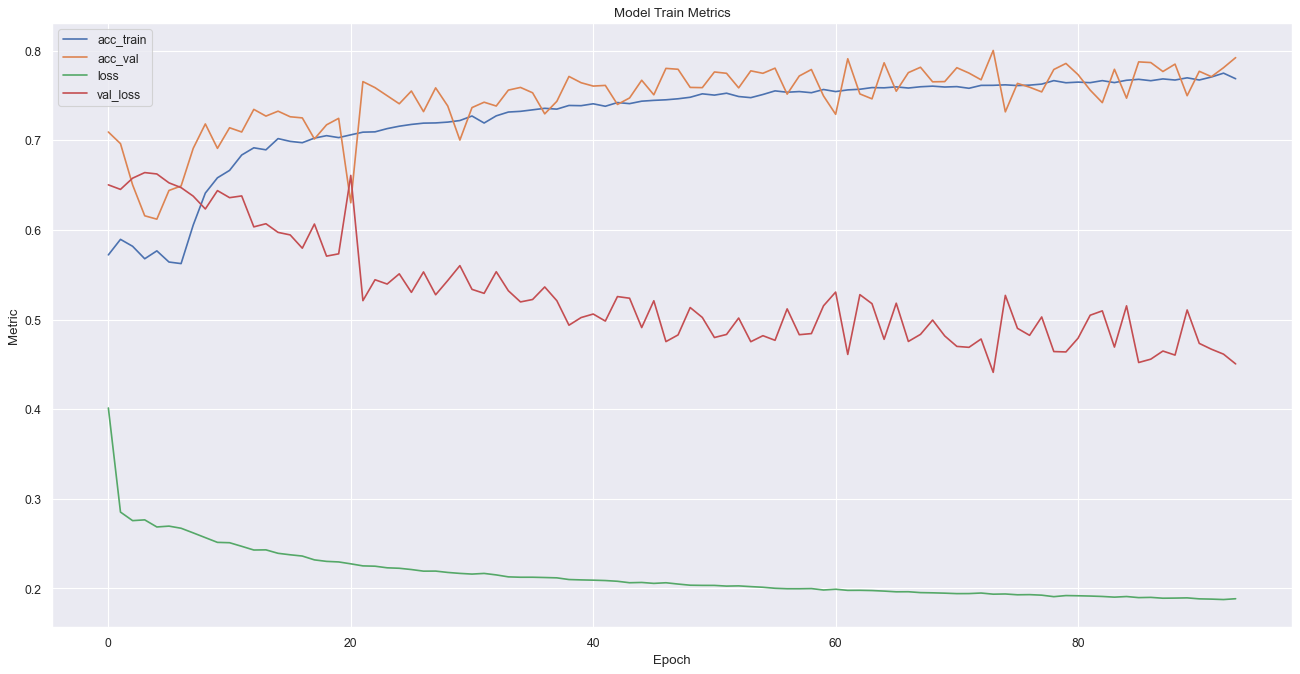

In [47]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(20,10), dpi=80)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train Metrics')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['acc_train', "acc_val",'loss',"val_loss"])
plt.show()

In [48]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      7321
         1.0       0.59      0.71      0.64      2679

    accuracy                           0.79     10000
   macro avg       0.74      0.76      0.75     10000
weighted avg       0.81      0.79      0.80     10000

